# Finding induction heads

with repeating random sequences of tokens

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from circuitsvis.attention import attention_patterns, attention_heads

torch.set_grad_enabled(False) # we like to turn off gradient tracking if we don't use them, as it uses a lot of memory
g = torch.manual_seed(1234) # this is to make sure when we run the random stuff, it's the same
torch.use_deterministic_algorithms(True) # same as above

In [3]:
model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b",device_map="auto",torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.


## Generating a sequence & running the model

First, let's generate a sequence of tokens. We don't want the sequence to contain any meaningful semantic structure, so we will literally randomly sample tokens. Then, we will repeat the sequence one more time. If you imagine each letter to be a token, this would be as follows:

```
cbadcbad
```


Let's have $100$ random tokens, and repeat it one more time.

In [4]:
# tokens are integer IDs afterall, so we just sample 100 integers between 1000 and 2000 (arbitrary)
token_ids = torch.randint(low=1000,high=2000,size=(100,))

# now we repeat the same sequence one more time
token_seq = torch.cat([token_ids, token_ids], dim=0).to(model.device)

# let's create another tensor with just one token in it, which is the beginning of sequence.
# normally, models always receive this token at the beginning
# torch.long means keep it as integers
bos_tensor = torch.Tensor([model.config.bos_token_id]).to(model.device).to(torch.long)

# now we combine the bos token tensor with the sequence we had
token_seq = torch.concat([bos_tensor,token_seq])

This is really gibberish if you decode the token IDs:

In [5]:
tokenizer.decode(token_seq)

'<bos> greattt pasнери///span count smmessageopleWhatsible such tea setangechendoessage didspanDe UniHespan Ind assAPaitcol fe dayMogoнеiel simmannameceraispankaero theirish nowumberри samemymathele alsoроcipovenswer cha downtleden keELcerдаForital поucalignedriteweenger == anyikful derTexticity," person how")substersions reshosecludesu);\rhosecreessage yearsónId greattt pasнери///span count smmessageopleWhatsible such tea setangechendoessage didspanDe UniHespan Ind assAPaitcol fe dayMogoнеiel simmannameceraispankaero theirish nowumberри samemymathele alsoроcipovenswer cha downtleden keELcerдаForital поucalignedriteweenger == anyikful derTexticity," person how")substersions reshosecludesu);\rhosecreessage yearsónId'

Let's run it now, and save the attention patterns.

In [6]:
# here output_attentions=True is important because it gives us the attention paterns
out = model(token_seq.unsqueeze(0),return_dict=True,output_attentions=True)
print(out['attentions'][2].shape)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


torch.Size([1, 8, 201, 201])


## ICL in behaviour?

Let's look at whether the model get's better at predicting the next token after the second repetition of the sequence starts.

In [7]:
def calc_icl_score(token_stream: torch.Tensor, logits: torch.Tensor) -> torch.Tensor:  
    """
    This function extracts probabilities from the logits for tokens that are observed
    but only for the positions where these tokens actually appear in the token stream.

    Args:
        token_stream (torch.Tensor): Token  tensor of shape `sequence` containing the input token IDs
        logits (torch.Tensor): Logit tensor of shape `sequence` by `vocabulary`
    Returns:
        torch.Tensor: A tensor of probabilities for tokens that occur in the token stream
    """

    # first, we turn the logits into probabilities by applying a softmax
    # dim=-1, because softmax is applied to each position in the sequence separately, over the entire vocabulary
    probabilities = F.softmax(logits, dim=-1)
    
    # token_idx - 1 because we need the logits from the previous token
    # the softmax-logit in position x gives you the probabilities for the token at position x+1
    # so this gives us which vocab id we are looking for at each position
    indices, ids = zip(*[(token_idx - 1, token) for token_idx, token in enumerate(token_stream)])
    selected_probabilities = probabilities[indices, ids]
    return selected_probabilities

In [8]:
score = calc_icl_score(token_seq,out["logits"].squeeze()).cpu()

In [9]:
torch.argmax(score)

tensor(171)

In [10]:
token_seq[171]

tensor(1669, device='mps:0')

In [11]:
tokenizer.decode(1669)

'uc'

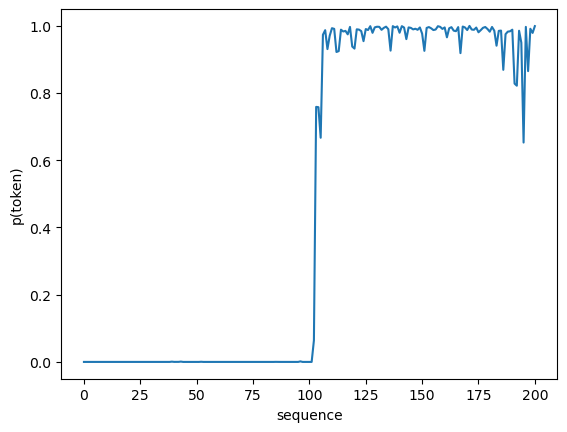

In [12]:
plt.plot(score.to(float))
plt.ylabel("p(token)")
plt.xlabel("sequence")
plt.show()

Success! There seems to be learning

## Building 'model' induction heads

To identify induction heads, we first need to explicitly create attention patterns that we think these heads would produce.

That means, if we have a token sequence `I love pizza. I love pizza.`, we need to create an attention pattern, where the second `I` attends to the first `love`, and the second `love` attends to the first `pizza`. This is assuming each word is a token.

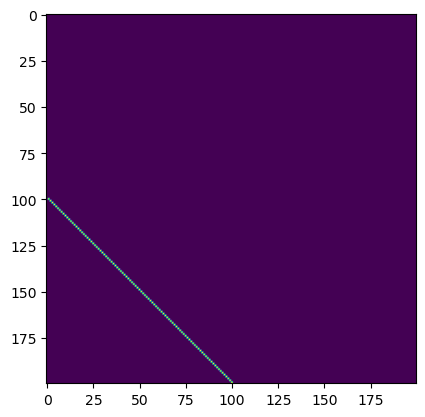

In [13]:
seq_len = len(token_seq)

# we want to look as back as the length of the original sequence, but 1 less.
# you can derive this yourself as well from the pizza example above.
look_back  = seq_len//2 - 1

# initialise a square attention matrix of zeros
induction_mask = torch.zeros(seq_len,seq_len).to(float)

# populate the attention matrix
for example in range(seq_len//2+1, seq_len): # from +1 because of <bos> token
    induction_mask[example,example-look_back]=1.

# we don't want to keep the bos token for now
induction_mask = induction_mask[1:,1:] # ignore <bos>

plt.imshow(induction_mask)
plt.show()

In [14]:
print(induction_mask.shape)

torch.Size([200, 200])


What does the $100$th token attend to?

In [15]:
induction_mask[99]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

Nothing, because the sequence has not started to repeat yet. What about the 101th token?

In [16]:
induction_mask[100]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64)

It attends the $2$nd token, because that is what is likely to come next!

## Computing the induction head score


For each head in each layer, we extract the attention pattern. Note that we are only interested in the lower triangular part, as the upper triangle is always $0$ because of the causal mask.

We flatten the lower triangular of the `induction_mask` we created above, as well as the actual head attention patterns. 

We then take a dot product between the two vectors, which essentially tells us how similar they are. 

Lastly, we normalise this number by the sum of the attention pattern. This is needed, because otherwise its easy to cheat the dot product. For example, if the head attends to every token, it would then still have a high dot product with the induction_mask vector. 

The resultant score is between $0$ and $1$ for each had, where higher score indicates more induction head-like behaviour.

In [17]:
num_heads = model.config.num_attention_heads
num_layers = model.config.num_hidden_layers

induction_scores = torch.zeros(num_layers,num_heads)
tril = torch.tril_indices(seq_len-1,seq_len-1)

induction_flat = induction_mask[tril[0],tril[1]].flatten()
for layer in range(num_layers):
    for head in range(num_heads):
        pattern = out["attentions"][layer][0][head].cpu().to(float)[1:,1:] # ignore <bos>
        pattern_flat = pattern[tril[0], tril[1]].flatten()


        score = (induction_flat @ pattern_flat) / pattern_flat.sum()

        induction_scores[layer, head] = score

In [18]:
induction_scores.device

device(type='cpu')

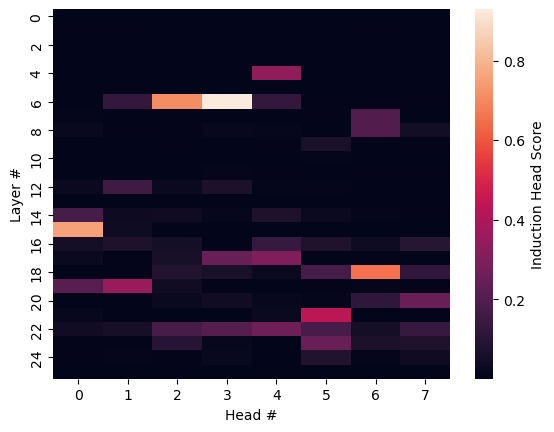

In [19]:
fig,ax = plt.subplots()
sns.heatmap(induction_scores,  cbar_kws={'label': 'Induction Head Score'},ax=ax)
ax.set_ylabel("Layer #")
ax.set_xlabel("Head #")
plt.show()

We have some really high scoring heads! Let's take the top scoring head, and look at its behaviour.

In [20]:
layer, head = torch.unravel_index(induction_scores.argmax(), induction_scores.shape)

In [21]:
induction_scores.shape

torch.Size([26, 8])

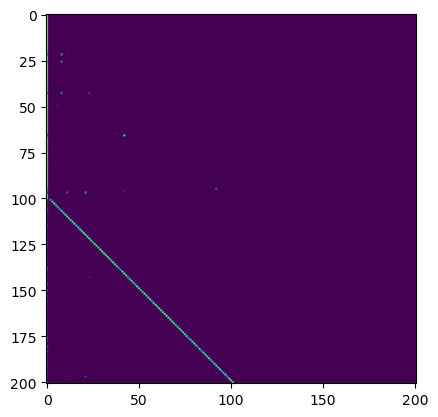

In [22]:
plt.imshow(out["attentions"][layer][0][head].cpu().float())
plt.show()

We see that nice diagonal pattern that starts from the second repeat of the sequence that we created above! It matches that quite nicely. You will also see that during the first repetition of the sequence, the head really likes attending to the `<bos>` token at the beginning. It's not a defined characteristic of the induction head we created, but I think it's quite common for these models.

## Visualising attention patterns over tokens

To do this, we use the awesome but poorly documented `circuistvis` library. Of particular interest is the `attention_patterns` function we imported. Let's see what it expects from us as inputs:

In [23]:
attention_patterns?

Signature:
attention_patterns(
    tokens: List[str],
    attention: Union[list, numpy.ndarray, torch.Tensor],
) -> circuitsvis.utils.render.RenderedHTML
Docstring:
Attention Patterns

Visualization of attention head patterns.

@deprecated Use `attention_heads` instead.

Args:
    tokens: List of tokens (e.g. `["A", "person"]`)
    attention: Attention tensor of the shape [num_heads x dest_tokens x
    src_tokens]

Returns:
    Html: Attention patterns visualization
File:      /opt/miniconda3/envs/helmholtz/lib/python3.10/site-packages/circuitsvis/attention.py
Type:      function

So we need to provide:

- Tokenized text as a list
- A 3D tensor of attention patterns, whose shape you can see above

Let's again visualise Layer $6$, which contains the most induction-like head, which is Head $3$.

Right now, we have more than $200$ tokens, which is a bit too much to visualise. So let's create a shorter sequence and visualise the model's attention patterns over this shorter sequence.

In [24]:
prompt = "I love pizza. I love pizza."
short_input = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
short_output = model(short_input,return_dict=True,output_attentions=True)

In [25]:
# we first decode the token sequence back to a string and then tokenize it (i.e. split it into subwords)
tokens = tokenizer.tokenize(tokenizer.decode(short_input.squeeze()))

# we index into 0 for the attentions because that is the batch dimension
attention_patterns(tokens,short_output["attentions"][layer][0])

In [26]:
tokens

['<bos>', 'I', '▁love', '▁pizza', '.', '▁I', '▁love', '▁pizza', '.']

Particularly, if you look at Head 2, you will see that it has a very special pattern. It looks at the previous sequence and finds the token that occured after it. Click on Head 2, and hover over different tokens to see where they attend to. Does it look like an induction head?

Let's do this one more time, but with a random sequence of tokens. This time, let's do $10$ and not $100$.

In [27]:
token_ids = torch.randint(low=1000,high=2000,size=(10,))
token_seq = torch.cat([token_ids, token_ids], dim=0).to(model.device)
bos_tensor = torch.Tensor([model.config.bos_token_id]).to(model.device).to(torch.long)
token_seq = torch.concat([bos_tensor,token_seq])

In [28]:
short_output = model(token_seq.unsqueeze(0),return_dict=True,output_attentions=True)
# we first decode the token sequence back to a string and then tokenize it (i.e. split it into subwords)
tokens = tokenizer.tokenize(tokenizer.decode(token_seq.squeeze()))

# we index into 0 for the attentions because that is the batch dimension
attention_patterns(tokens,short_output["attentions"][layer][0])

Still behaves like an induction head. Success!

Some questions and exercises:

- We have only looked at the top scoring head. Do the other high scoring heads behave similarly?
- When does a head qualify as an induction head? Is there a cutoff score? (There is no clear answer for this)
- If you prompt the model like `Macron is the president of Germany. Macron is the president of Germany. Macron is the president of` vs. `Macron is the president of France. Macron is the president of France. Macron is the president of`, is there a noticeable difference in the pattern of induction heads? It would be best to answer this using qualitative comparisons like we do above, but also using some numbers. e.g., does the probability of attending to the country name go down when it's a lie vs not. You can also think about gathering all the induction head attention patterns into one 3d tensor and visualise them together like above, instead of going layer by layer.
- What about if you just test `Macron is the president of Germany. Macron is the president of` vs. `Macron is the president of France. Macron is the president of`. Here, the model still outputs the correct answer in both cases (i.e. France), but are the attention patterns any different.

In [29]:
attention_heads(short_output["attentions"][layer][0], tokens)